In [33]:
import os
import json
import torch
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from dotenv import load_dotenv
from huggingface_hub import login
from transformers import AutoModelForCausalLM, AutoTokenizer
from datasets import load_dataset
from evaluate import load


In [ ]:
warnings.filterwarnings("ignore")
load_dotenv()
login(token=os.getenv("HUGGINGFACE_TOKEN"))

In [ ]:
# data for kas_Deva, mni_Beng,snd_Arab  not in IN22-Gen
# In_langs = ['asm_Beng','ben_Beng','brx_Deva','doi_Deva','eng_Latn','gom_Deva','guj_Gujr','hin_Deva','kan_Knda','kas_Arab','kas_Deva','mai_Deva','mal_Mlym','mar_Deva','mni_Beng','mni_Mtei','npi_Deva','ory_Orya','pan_Guru','san_Deva','sat_Olck','snd_Arab','snd_Deva','tam_Taml','tel_Telu','urd_Arab']
In_langs = ['asm_Beng','ben_Beng','brx_Deva','doi_Deva','eng_Latn','gom_Deva','guj_Gujr','hin_Deva','kan_Knda','kas_Arab','mai_Deva','mal_Mlym','mar_Deva','mni_Mtei','npi_Deva','ory_Orya','pan_Guru','san_Deva','sat_Olck','snd_Deva','tam_Taml','tel_Telu','urd_Arab']


In [ ]:
code_lang_map = {
    'asm_Beng': 'Assamese',
    'ben_Beng': 'Bengali',
    'brx_Deva': 'Bodo',
    'doi_Deva': 'Dogri',
    'eng_Latn': 'English',
    'gom_Deva': 'Konkani',
    'guj_Gujr': 'Gujarati',
    'hin_Deva': 'Hindi',
    'kan_Knda': 'Kannada',
    'kas_Arab': 'Kashmiri',
    'mai_Deva': 'Maithili',
    'mal_Mlym': 'Malayalam',
    'mar_Deva': 'Marathi',
    'mni_Mtei': 'Meiteilon',
    'npi_Deva': 'Nepali',
    'ory_Orya': 'Odia',
    'pan_Guru': 'Punjabi',
    'san_Deva': 'Sanskrit',
    'sat_Olck': 'Santali',
    'snd_Deva': 'Sindhi',
    'tam_Taml': 'Tamil',
    'tel_Telu': 'Telugu',
    'urd_Arab': 'Urdu'
}

In [ ]:
lang_code_map = {
    'Assamese': 'asm_Beng',
    'Bengali': 'ben_Beng',
    'Bodo': 'brx_Deva',
    'Dogri': 'doi_Deva',
    'English': 'eng_Latn',
    'Konkani': 'gom_Deva',
    'Gujarati': 'guj_Gujr',
    'Hindi': 'hin_Deva',
    'Kannada': 'kan_Knda',
    'Kashmiri': 'kas_Arab',
    'Maithili': 'mai_Deva',
    'Malayalam': 'mal_Mlym',
    'Marathi': 'mar_Deva',
    'Meiteilon': 'mni_Mtei',
    'Nepali': 'npi_Deva',
    'Odia': 'ory_Orya',
    'Punjabi': 'pan_Guru',
    'Sanskrit': 'san_Deva',
    'Santali': 'sat_Olck',
    'Sindhi': 'snd_Deva',
    'Tamil': 'tam_Taml',
    'Telugu': 'tel_Telu',
    'Urdu': 'urd_Arab'
}
    

In [ ]:
ds  = load_dataset("ai4bharat/IN22-Gen")

In [ ]:
ds = ds['test']

In [ ]:
ds['eng_Latn'][:5]

In [ ]:
model_name = "sarvamai/sarvam-translate"

In [ ]:
# Load tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name).to('cuda:0')

In [ ]:
# All the translations will be saved in this dict
results={}

In [ ]:
# Load existing results if available
try:
    with open("translations_sarvam_in22.json", "r",encoding="utf-8") as f:
        results = json.load(f)
except:
    print("File does not exist")

In [ ]:
def translate(sentences, src_lang,tgt_lang, batch_size=8):
    model.eval()
    translations = []
    print("**"*20, end=" ")
    print(f"Translating from {src_lang} to {tgt_lang}",end=" ")
    print("**"*20)
    with torch.inference_mode():
        for i in range(0, len(sentences), batch_size):
            batch = sentences[i:i+batch_size]

            # Build messages for each sentence in the batch
            messages = [
                [
                    {"role": "system", "content": f"Translate the text below from {src_lang} to {tgt_lang}."},
                    {"role": "user", "content": sent}
                ]
                for sent in batch
            ]

            # Apply chat template to each
            inputs = [tokenizer.apply_chat_template(m, tokenize=False, add_generation_prompt=True) for m in messages]

            # Tokenize and move to device
            model_inputs = tokenizer(inputs, return_tensors="pt", padding="max_length", max_length=1024, truncation=True).to(model.device)

            # Generate
            generated_ids = model.generate(
                **model_inputs,
                max_new_tokens=1024,
                do_sample=False,
                # temperature=0.01,
                num_return_sequences=1
            )

            # Decode only new tokens for each sentence
            for j, gen in enumerate(generated_ids):
                output_ids = gen[len(model_inputs.input_ids[j]):].tolist()
                output_text = tokenizer.decode(output_ids, skip_special_tokens=True)
                translations.append(output_text.strip())
            
            print(f"Processed {i + len(batch)}/{len(sentences)} sentences", end='\r')
            
            # Clean up to save memory
            del model_inputs, generated_ids
            torch.cuda.empty_cache()

    return translations

Indian to Indain languages translation is not supported by this model. Indian to English and English to Indian is alone possible.

## English to Indian Language Translation

In [ ]:
for src_lang in ['eng_Latn']:
    if src_lang not in results:
        results[src_lang] = {}
    for tgt_lang in In_langs:
        if results[src_lang].get(f'{src_lang}-{tgt_lang}'):
            print(f"Skipping {src_lang} to {tgt_lang}, already exists.")
            continue
        out = translate(ds[src_lang], code_lang_map[src_lang], code_lang_map[tgt_lang])
        results[src_lang][f'{src_lang}-{tgt_lang}'] = out

        # One every translation pair, save to a file

        try:
            with open("translations_sarvam_in22.json", "w", encoding="utf-8") as f:
                json.dump(results, f, indent=4, ensure_ascii=False)
                print(f"File saved as of {tgt_lang}")
        except IOError as e:
            print(f"Error saving file: {e}")

## Indian Languages to English Translation

In [ ]:
for src_lang in In_langs:
    if src_lang not in results:
        results[src_lang] = {}
    for tgt_lang in ['eng_Latn']:
        if results[src_lang].get(f'{src_lang}-{tgt_lang}'):
            print(f"Skipping {src_lang} to {tgt_lang}, already exists.")
            continue
        out = translate(ds[src_lang], code_lang_map[src_lang], code_lang_map[tgt_lang])
        results[src_lang][f'{src_lang}-{tgt_lang}'] = out

        # One every translation pair, save to a file

        try:
            with open("translations_sarvam_in22.json", "w", encoding="utf-8") as f:
                json.dump(results, f, indent=4, ensure_ascii=False)
                print(f"File saved as of {tgt_lang}")
        except IOError as e:
            print(f"Error saving file: {e}")

In [ ]:
results['eng_Latn'].keys()

## Evaluation with chrF++

In [ ]:
chrf = load("chrf")

In [ ]:
evaluation_results = {}

In [ ]:
def reshape_to_2D(lst):
    return np.array(lst).reshape(-1,1).tolist()

In [ ]:
for src_lang in In_langs:
    evaluation_results[src_lang] = {}
    for tgt_lang in In_langs:
        pair = f'{src_lang}-{tgt_lang}'
        if pair not in results[src_lang]:
            continue
        print(f"Evaluating {src_lang}-{tgt_lang}")
        # print(results[src_lang][pair][0])
        # print(ds[src_lang][0])
        eval_score = chrf.compute(predictions=results[src_lang][pair], references=reshape_to_2D(ds[tgt_lang]), word_order = 2)
        evaluation_results[src_lang][pair] = round(eval_score['score'])

In [26]:
evaluation_results

{'asm_Beng': {'asm_Beng-eng_Latn': 56},
 'ben_Beng': {'ben_Beng-eng_Latn': 54},
 'brx_Deva': {'brx_Deva-eng_Latn': 49},
 'doi_Deva': {'doi_Deva-eng_Latn': 56},
 'eng_Latn': {'eng_Latn-asm_Beng': 46,
  'eng_Latn-ben_Beng': 49,
  'eng_Latn-brx_Deva': 48,
  'eng_Latn-doi_Deva': 58,
  'eng_Latn-eng_Latn': 90,
  'eng_Latn-gom_Deva': 45,
  'eng_Latn-guj_Gujr': 53,
  'eng_Latn-hin_Deva': 57,
  'eng_Latn-kan_Knda': 52,
  'eng_Latn-kas_Arab': 35,
  'eng_Latn-mai_Deva': 50,
  'eng_Latn-mal_Mlym': 48,
  'eng_Latn-mar_Deva': 51,
  'eng_Latn-mni_Mtei': 45,
  'eng_Latn-npi_Deva': 50,
  'eng_Latn-ory_Orya': 48,
  'eng_Latn-pan_Guru': 48,
  'eng_Latn-san_Deva': 38,
  'eng_Latn-sat_Olck': 40,
  'eng_Latn-snd_Deva': 39,
  'eng_Latn-tam_Taml': 51,
  'eng_Latn-tel_Telu': 52,
  'eng_Latn-urd_Arab': 65},
 'gom_Deva': {'gom_Deva-eng_Latn': 46},
 'guj_Gujr': {'guj_Gujr-eng_Latn': 56},
 'hin_Deva': {'hin_Deva-eng_Latn': 57},
 'kan_Knda': {'kan_Knda-eng_Latn': 54},
 'kas_Arab': {'kas_Arab-eng_Latn': 50},
 'mai_

## Visualize Results

In [27]:
dataframe = pd.DataFrame(columns=In_langs, index= In_langs)

In [28]:
dataframe

,asm_Beng,ben_Beng,brx_Deva,doi_Deva,eng_Latn,gom_Deva,guj_Gujr,hin_Deva,kan_Knda,kas_Arab,...,mni_Mtei,npi_Deva,ory_Orya,pan_Guru,san_Deva,sat_Olck,snd_Deva,tam_Taml,tel_Telu,urd_Arab
asm_Beng,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ben_Beng,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
brx_Deva,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
doi_Deva,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
eng_Latn,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
gom_Deva,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
guj_Gujr,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
hin_Deva,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
kan_Knda,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
kas_Arab,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [29]:
for src_lang, targets in evaluation_results.items():
    for target_key, score in targets.items():
        tgt_lang = target_key.split("-")[1]
        dataframe.loc[src_lang,tgt_lang] = score

In [30]:
dataframe = dataframe.fillna(0)

In [31]:
dataframe

,asm_Beng,ben_Beng,brx_Deva,doi_Deva,eng_Latn,gom_Deva,guj_Gujr,hin_Deva,kan_Knda,kas_Arab,...,mni_Mtei,npi_Deva,ory_Orya,pan_Guru,san_Deva,sat_Olck,snd_Deva,tam_Taml,tel_Telu,urd_Arab
asm_Beng,0,0,0,0,56,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ben_Beng,0,0,0,0,54,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
brx_Deva,0,0,0,0,49,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
doi_Deva,0,0,0,0,56,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
eng_Latn,46,49,48,58,90,45,53,57,52,35,...,45,50,48,48,38,40,39,51,52,65
gom_Deva,0,0,0,0,46,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
guj_Gujr,0,0,0,0,56,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
hin_Deva,0,0,0,0,57,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
kan_Knda,0,0,0,0,54,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
kas_Arab,0,0,0,0,50,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


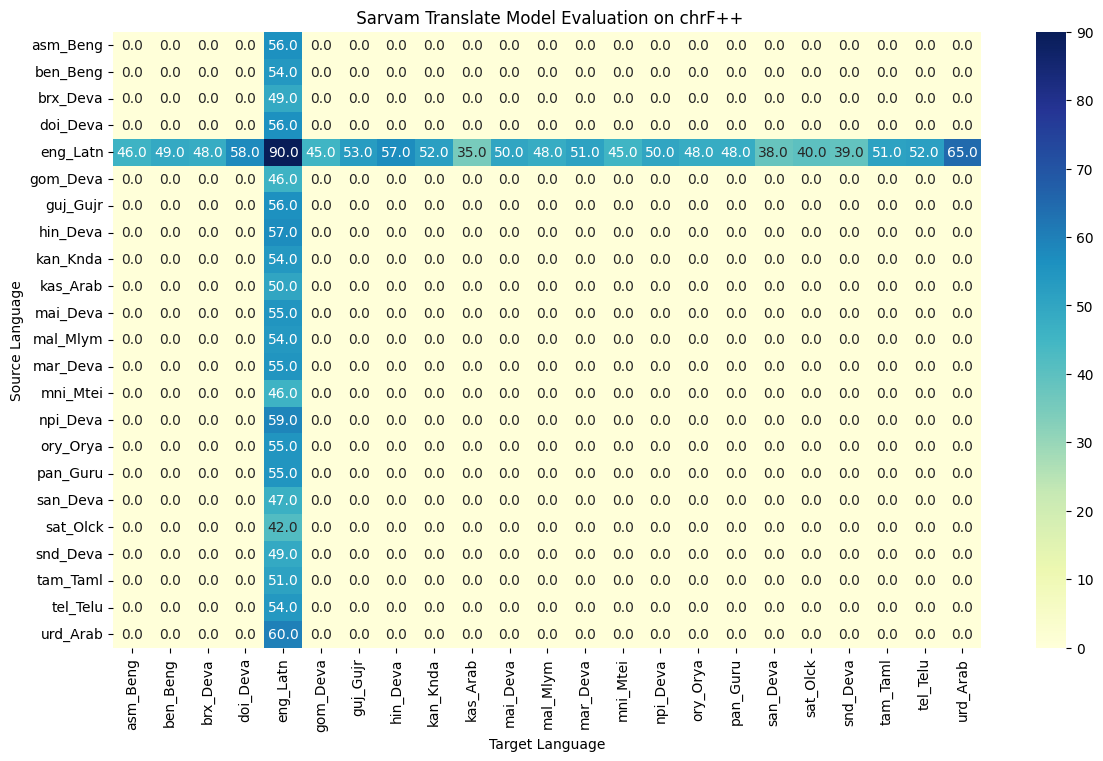

In [42]:
plt.figure(figsize=(14,8))
sns.heatmap(data=dataframe,annot=True, fmt='.1f', cmap='YlGnBu' )
plt.xlabel("Target Language")
plt.ylabel("Source Language")
plt.title(" Sarvam Translate Model Evaluation on chrF++")
plt.show()